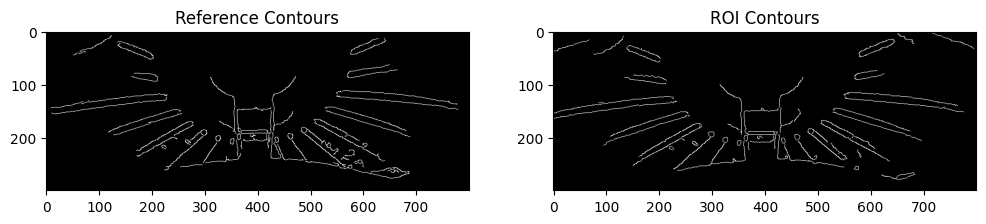

Contour 1 Shape Score: 82.97357800482614
Contour 2 Shape Score: 61.36528186758362
Contour 3 Shape Score: 82.86002886342715
Contour 4 Shape Score: 69.39520711772914
Contour 5 Shape Score: 81.95433641472951
Contour 6 Shape Score: 84.13235353013738
Contour 7 Shape Score: 76.31256158088499
Contour 8 Shape Score: 80.69058060507338
Contour 9 Shape Score: 82.61726813995595
Contour 10 Shape Score: 51.29700082353747
Contour 11 Shape Score: 61.22665083746578
Contour 12 Shape Score: 1.7976931348623157e+308
Contour 13 Shape Score: 81.90220589929858
Contour 14 Shape Score: 43.84389350111558
Contour 15 Shape Score: 61.330244430742084
Contour 16 Shape Score: 81.86348304690455
Contour 17 Shape Score: 76.81230649108734
Contour 18 Shape Score: 82.15998885380614
Contour 19 Shape Score: 76.34416273119388
Contour 20 Shape Score: 61.37537997632073
Contour 21 Shape Score: 81.75933212267594
Contour 22 Shape Score: 80.19271623158814
Contour 23 Shape Score: 82.39094296664864
Contour 24 Shape Score: 82.805446301

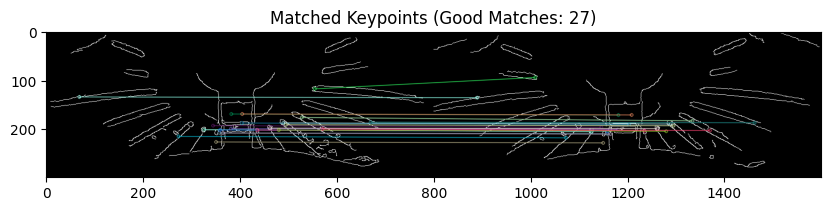

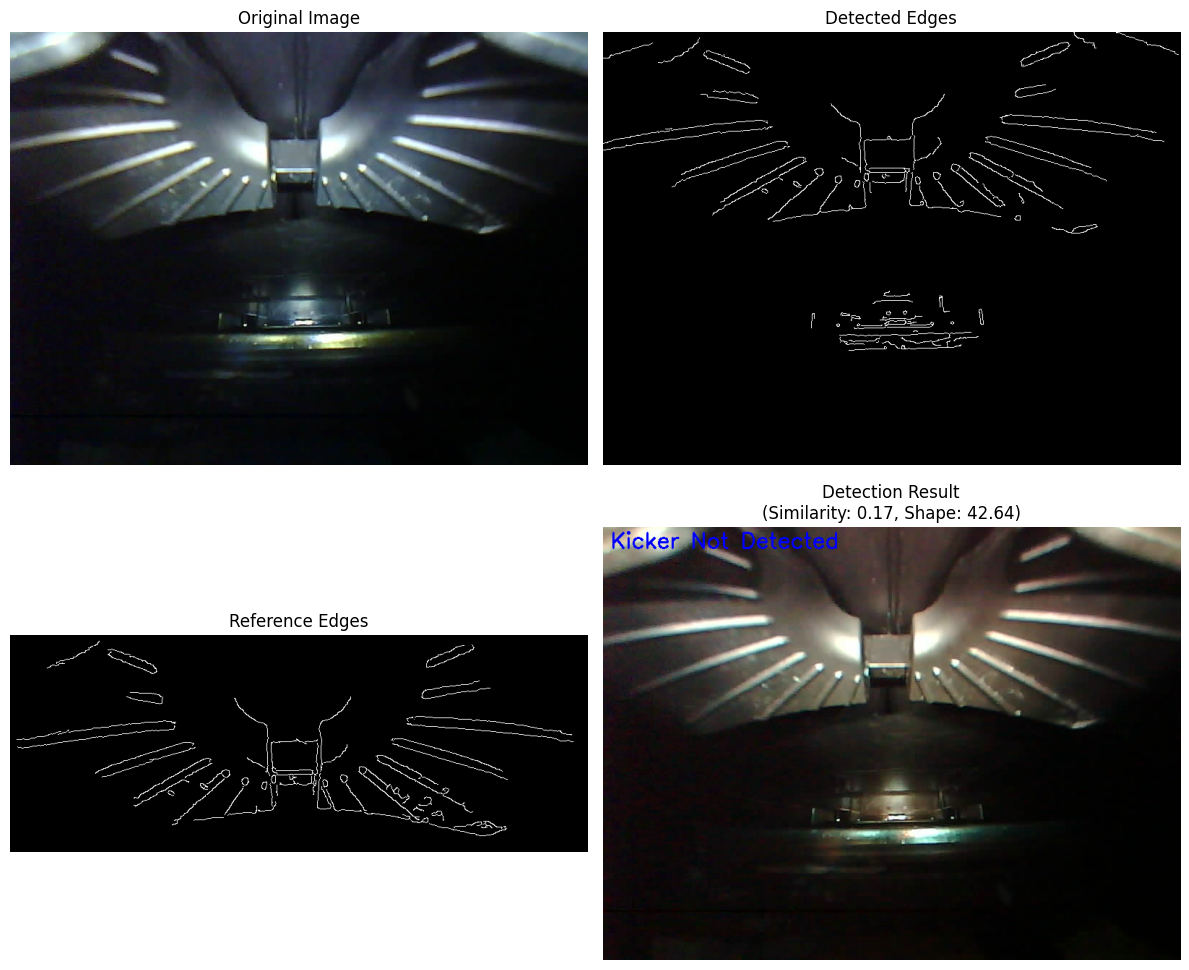

No kicker detected.


False

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect kicker using shape matching and SIFT feature matching with FLANN
def detect_kicker_with_sift_and_flann(image_path, reference_roi, reference_edges, threshold=0.4):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return None  # Return None if the image is not found

    # Step 1: Image Preprocessing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Step 2: Edge Detection
    edges = cv2.Canny(blurred_image, 50, 150)

    # Step 3: Define ROI (upper half of the image)
    height, width = edges.shape
    roi = edges[0:int(height/2), 0:width]

    # Step 4: Contour Analysis (debug: display contours for clarity)
    contours_ref, _ = cv2.findContours(reference_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_roi, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours_ref or not contours_roi:
        print("No contours found in one of the images.")
        return None

    # Find the largest contour in the reference image (assumed to be the kicker)
    ref_contour = max(contours_ref, key=cv2.contourArea)

    # Debug: Display the reference and ROI contours
    image_contours = np.zeros_like(roi)
    cv2.drawContours(image_contours, contours_roi, -1, (255, 255, 255), 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(reference_edges, cmap='gray')
    plt.title("Reference Contours")

    plt.subplot(1, 2, 2)
    plt.imshow(image_contours, cmap='gray')
    plt.title("ROI Contours")
    plt.show()

    # Shape Matching: Compare each contour in ROI to the reference contour
    shape_scores = []
    for i, contour in enumerate(contours_roi):
        shape_score = cv2.matchShapes(ref_contour, contour, cv2.CONTOURS_MATCH_I1, 0.0)
        shape_scores.append(shape_score)
        print(f"Contour {i + 1} Shape Score: {shape_score}")

    # Minimum shape score indicates the closest match
    min_shape_score = min(shape_scores) if shape_scores else 1.0
    print(f"Minimum Shape Score: {min_shape_score}")

    # Step 5: Feature Matching with SIFT and FLANN
    sift = cv2.SIFT_create()
    keypoints_ref, descriptors_ref = sift.detectAndCompute(reference_edges, None)
    keypoints_roi, descriptors_roi = sift.detectAndCompute(roi, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # Increase the number of checks for better precision

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    if descriptors_ref is not None and descriptors_roi is not None:
        # Match descriptors using FLANN
        matches = flann.knnMatch(descriptors_ref, descriptors_roi, k=2)

        # Store only good matches (using Lowe's ratio test)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        # Calculate similarity score based on good matches
        similarity_score = len(good_matches) / len(matches) if matches else 0
        print(f"Total Matches: {len(matches)}")
        print(f"Good Matches: {len(good_matches)}")
        print(f"Similarity Score: {similarity_score:.2f}")
    else:
        similarity_score = 0

    # Debug: Visualize the matches between the keypoints
    matched_image = cv2.drawMatches(reference_edges, keypoints_ref, roi, keypoints_roi, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 10))
    plt.imshow(matched_image)
    plt.title(f"Matched Keypoints (Good Matches: {len(good_matches)})")
    plt.show()

    # Decision based on both shape matching and feature matching
    kicker_detected = (min_shape_score <= 0.5) and (similarity_score >= threshold)

    # Visualization of the result
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Detected Edges")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(reference_edges, cmap='gray')
    plt.title("Reference Edges")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(image, cmap='gray')
    if kicker_detected:
        cv2.putText(image, f"Kicker Detected! (Similarity: {similarity_score:.2f}, Shape: {min_shape_score:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(image, "Kicker Not Detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    plt.imshow(image)
    plt.title(f"Detection Result\n(Similarity: {similarity_score:.2f}, Shape: {min_shape_score:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    if kicker_detected:
        print(f"Kicker detected with similarity score: {similarity_score:.2f} and shape score: {min_shape_score:.2f}")
    else:
        print("No kicker detected.")

    return kicker_detected

# Test the function with the reference images
reference_roi = cv2.imread('Reference_Imgs/reference_roi.jpg', cv2.IMREAD_GRAYSCALE)
reference_edges = cv2.imread('Reference_Imgs/reference_edges.jpg', cv2.IMREAD_GRAYSCALE)

detect_kicker_with_sift_and_flann('image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at front position/Trial 3.jpg', reference_roi, reference_edges, threshold=0.7)
